## CONTINUOUS DC SERVO MODEL DISCOVERY

In [1]:
# Importing necessary Libraries

import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as skm

In [2]:
data = scipy.io.loadmat("/home/aman/ACL/Servo-Motor-System-Identification/Data/Training_Set.mat")

In [3]:
class motor_param:
    def  __init__(self, PW, RPM):
        self.Pulse_Width = PW 
        self.Motor_RPM = RPM

In [4]:
anti_clock = motor_param(data["Training_set"][0][0][0][0][0][0], data["Training_set"][0][0][0][0][0][1])

In [5]:
clock = motor_param(data["Training_set"][0][0][1][0][0][0], data["Training_set"][0][0][1][0][0][1])

Text(0, 0.5, 'Motor_RPM')

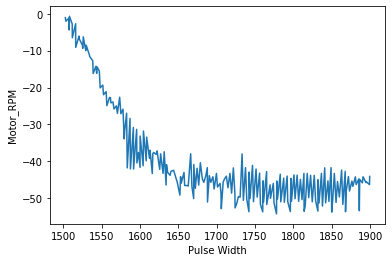

In [6]:
plt.plot(anti_clock.Pulse_Width, anti_clock.Motor_RPM)
plt.xlabel("Pulse Width")
plt.ylabel("Motor_RPM")

### Noise Removal
Denoising the data by using moving average filter with a window size of 4


In [7]:
def moving_avg(data, win_sz):
    fil = np.zeros((len(data), 1))
    for i in range(len(data)):
        if i < len(data) - win_sz:
            fil[i] = np.mean(data[i:i+win_sz])
        elif i< len(data)-1:
            fil[i] = np.mean(data[i:-1])
        else:
            fil[i] = data[i]
            
    return fil

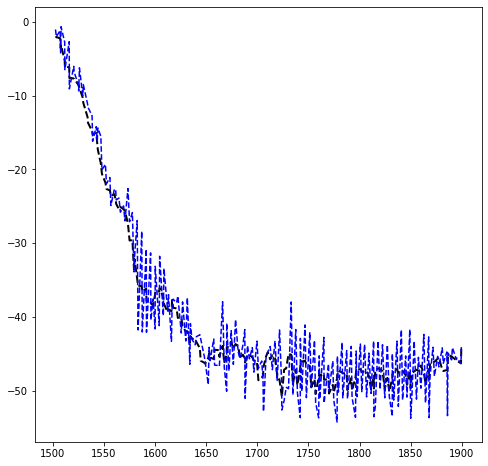

In [8]:
y_fil =  moving_avg(anti_clock.Motor_RPM, 4)

#Plots

plt.figure(figsize = (8, 8))
plt.plot(anti_clock.Pulse_Width, y_fil, "--k", linewidth = 2)
plt.plot(anti_clock.Pulse_Width, anti_clock.Motor_RPM, "--b")

### Regression model
Using Least square regression for parameter identification

In [9]:
def ls(y,A):
    x = np.linalg.inv(A.T @ A) @ A.T @ y
    return x

### Modelling
1) Using the following function:- $$y = ae^{-kx} + b$$
Where:-<br>$y$:- Motor RPM <br> $x$:- Pulse Width <br> $b$:- is constant

In [10]:
# Model Parameter
k = 0.014519

In [11]:
def function_one(PW, k):
    A = np.zeros((len(PW), 2))
    
    for i in range(len(PW)):
        A[i][0] = np.exp(-PW[i] * k)
        A[i][1] = 1
        
    return A

In [12]:
A_anti = function_one(anti_clock.Pulse_Width, k)

x_param = ls(y_fil, A_anti)

a = x_param[0]
b = x_param[1]

# Model Parameters
print("a:", a)
print("b:", b)

a: [1.55416005e+11]
b: [-48.76423215]


In [13]:
def model_anti(a, b, k, PW):
    y = np.zeros((len(PW), 1))
    
    for i in range(len(PW)):
        y[i] = a*np.exp(-k * PW[i]) + b
        
    return y

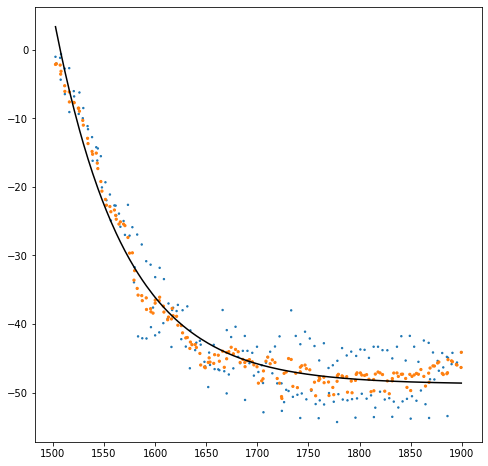

In [14]:
ypred = model_anti(a, b, k, anti_clock.Pulse_Width)

#Plots
plt.figure(figsize=(8,8))
plt.plot(anti_clock.Pulse_Width, ypred, "-k")
plt.scatter(anti_clock.Pulse_Width, anti_clock.Motor_RPM, 2*np.ones(len(anti_clock.Pulse_Width)))
plt.scatter(anti_clock.Pulse_Width, y_fil, 5*np.ones(len(anti_clock.Pulse_Width)))

In [15]:
#Perfrmance Parametric

#np.square(ypred[5:] - y_fil[5:]).mean()
skm.mean_squared_error(y_fil, ypred)

3.6852758834259585

2) Here we will be fitting the data to the following function of Pulse Width $$\left[y = \frac{a}{b + ke^{-c(x-d)}} + e\right]$$  

In [16]:
# Model Parameters

b_anti = 0.29
c_anti = 0.018
d_anti = 1570
k_anti = 1

In [17]:
def function_two(PW, b, c, d, k):
    A = np.zeros((len(PW), 2))
    
    for i in range(len(PW)):
        A[i][0] = 1/(b + k * np.exp(c * (PW[i] - d)))
        A[i][1] = 1
        
    return A

In [18]:
A_anti_2 = function_two(anti_clock.Pulse_Width, b_anti, c_anti, d_anti, k_anti)
x_param_2 = ls(y_fil, A_anti_2)

# Model Parameters
a_anti = x_param_2[0]
e_anti = x_param_2[1]

print("a:", a_anti)
print("e:", e_anti)

a: [27.75540876]
e: [-48.84087902]


In [19]:
def model_anti_2(a, b, c, d, e, k, PW):
    y = np.zeros((len(PW), 1))
    
    for i in range(len(PW)):
        y[i] = a/(b + k * np.exp(c * (PW[i] - d))) + e
        
    return y

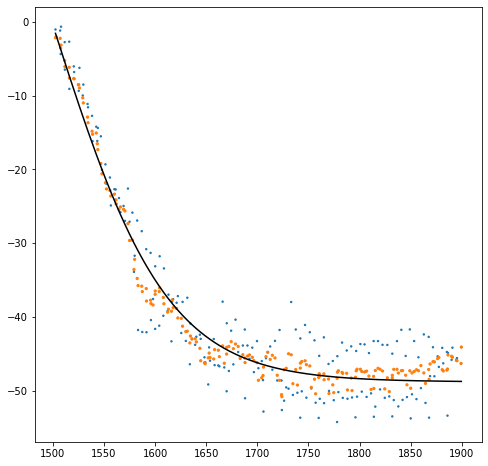

In [20]:
ypred_anti_2 = model_anti_2(a_anti, b_anti, c_anti, d_anti, e_anti, k_anti, anti_clock.Pulse_Width)
#print(ypred_anti_2)

plt.figure(figsize=(8,8))
plt.plot(anti_clock.Pulse_Width, ypred_anti_2, "-k")
plt.scatter(anti_clock.Pulse_Width, anti_clock.Motor_RPM, 2*np.ones(len(anti_clock.Pulse_Width)))
plt.scatter(anti_clock.Pulse_Width, y_fil, 5*np.ones(len(anti_clock.Pulse_Width)))


In [21]:
skm.mean_squared_error(y_fil, ypred_anti_2)

3.2471343997700592

Thus we get the follwing function of the continuous DC servo motor for anti-clockwise rotation
$$\left[y = \frac{27.75540876}{0.29 + e^{-0.018(x - 1570)}} - 48.84087902 \right]$$
Where, <br>
$y:-$ Motor RPM <br>
$x:-$ Pulse Width

### Clockwise Rotation data of the Motor

Text(0, 0.5, 'Motor RPM')

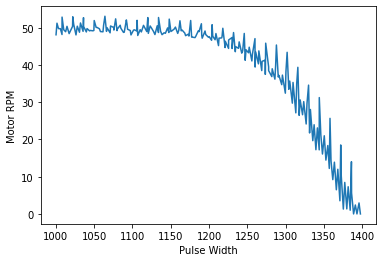

In [22]:
plt.plot(clock.Pulse_Width, clock.Motor_RPM)
plt.xlabel("Pulse Width")
plt.ylabel("Motor RPM")

#### Noise Removal
Denoising the data by using moving average filter with a window size of 3

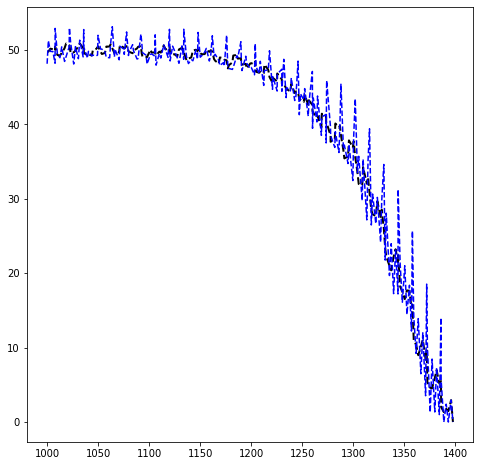

In [23]:
y_clock_fil = moving_avg(clock.Motor_RPM, 4)

plt.figure(figsize = (8, 8))
plt.plot(clock.Pulse_Width, y_clock_fil, "--k", linewidth = 2)
plt.plot(clock.Pulse_Width, clock.Motor_RPM, "--b")

## Clockwise Rotation
Here we will assume a similar function as above to which we will fit the data.
$$y = \frac{a}{b + ke^{-c(x - d)}} + e$$

In [24]:
# Model Paramaters

b_clock = 0.0901
k_clock = 1
c_clock = 0.0213634
d_clock = 1471

In [25]:
def function_clock(PW, b, k, c, d):
    A = np.zeros((len(PW), 2))
    
    for i in range(len(PW)):
        A[i][0] = 1/(b + k * np.exp(c * (PW[i] - d)))
        A[i][1] = 1
        
    return A

In [26]:
A_clock = function_clock(clock.Pulse_Width, b_clock, k_clock, c_clock, d_clock)
x_param_clock = ls(y_clock_fil, A_clock)

# Model Parameters
a_clock = x_param_clock[0]
e_clock = x_param_clock[1]

print("a:", a_clock)
print("e:", e_clock)

a: [6.47716715]
e: [-21.6429897]


In [27]:
def model_clock(a, b, c, d, e, k, PW):
    y = np.zeros((len(PW), 1))
    
    for i in range(len(PW)):
        y[i] = a/(b + k * np.exp(c * (PW[i] - d))) + e
        
    return y

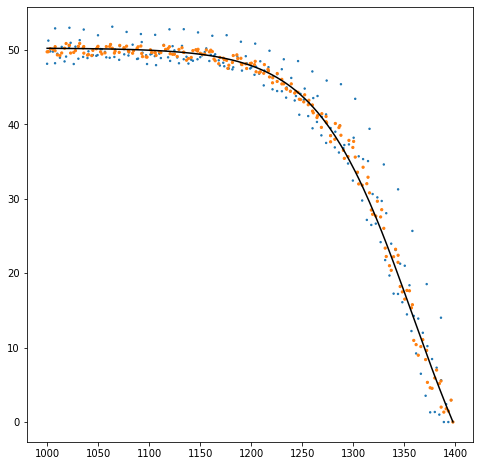

In [28]:
ypred_clock = model_clock(a_clock, b_clock, c_clock, d_clock, e_clock, k_clock, clock.Pulse_Width)
#print(ypred_anti_2)

plt.figure(figsize=(8,8))
plt.plot(clock.Pulse_Width, ypred_clock, "-k")
plt.scatter(clock.Pulse_Width, clock.Motor_RPM, 2*np.ones(len(clock.Pulse_Width)))
plt.scatter(clock.Pulse_Width, y_clock_fil, 5*np.ones(len(clock.Pulse_Width)))

In [29]:
skm.mean_squared_error(y_clock_fil, ypred_clock)

1.1738896409661346

Thus we get the following function for clockwise rotation of continuous DC Servo Motor
$$y = \left[\frac{6.47716715}{0.0901 + e^{-0.0213634(x - 1471)}} - 21.6429897 \right]$$